In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.optimize import curve_fit
from numpy import exp
from numpy import sin
from numpy import tanh


In [3]:
def e(z):
    #return 0.4
    #return sin(z*10)/2 + 0.5
    return 1-fraction_data[np.where(depth == z)[0]]

In [4]:
def H(z):
    return -tanh(((c2+c1)*(z-(c2+c1)/2))/(c2-c1))

In [5]:
def l (z,s,a1,b1,a2,b2):
    return e(z)/(1+exp(-a1*s+b1)) + (1-e(z))/(1+exp(-a2*s+b2))

In [6]:
def l_diff(z,s,a1,b1,a2,b2):
    return e(z) * (a1*exp(-a1*s+b1))/(1+exp(-a1*s+b1))**2 + (1-e(z)) * (a2*exp(-a2*s+b2))/(1+exp(-a2*s+b2))**2 

In [7]:
def integral(s,z,a1,a2,b1,b2):
    return H(z-s)*l_diff(z,s,a1,b1,a2,b2)

In [8]:
def functional_integration(z,a1,a2,b1,b2):        
    return quad(integral, 0, z, args=(z,a1,a2,b1,b2))[0]

In [16]:
def get_magnetisation(z,params):

    a1,a2,b1,b2 = params
    
    vec_expint = np.vectorize(functional_integration)
    M = vec_expint(z,a1,a2,b1,b2)
    
    return tanh(M*10**3)
    #return M

In [12]:
def hinge_loss(M, M_observed):
    # Вычисление hinge loss
    return np.mean(np.maximum(0, 1 - M * M_observed))

In [13]:
def smoothness_penalty(M, M_observed, weight=0.5):
    # Вычисление штрафа за изменения между соседними значениями
    diff = np.diff(M)
    diff_observed = np.diff(M_observed)
    penalty = np.mean((diff - diff_observed) ** 2)
    return weight * penalty

In [14]:
def combined_loss(M, M_observed, weight=0.5):
    # Объединенная функция потерь
    return hinge_loss(M, M_observed) + smoothness_penalty(M, M_observed, weight)

In [ ]:
def gradient_descent_with_momentum(observed_values,  x_values, params, learning_rate=0.01, iterations=1000, weight=0.5, momentum=0.9):
    # Инициализация момента
    velocity = np.zeros_like(params)
    
    for i in range(iterations):
        # Вычисляем значения функций f и g в точках x
        
        modeled_values = get_magnetisation(x_values, params)
        
        # Вычисляем текущую ошибку
        loss = combined_loss(modeled_values, observed_values, weight)
        
        # Вычисляем градиент ошибки по каждому параметру
        gradients = np.zeros_like(params)
        for j in range(len(params)):
            params_shifted = np.copy(params)
            params_shifted[j] += 1e-5
            values_shifted = get_magnetisation(x_values, params_shifted)
            loss_shifted = combined_loss(values_shifted, observed_values, weight)
            gradients[j] = (loss_shifted - loss) / 1e-5
        
        # Обновляем момент и параметры
        velocity = momentum * velocity - learning_rate * gradients
        params += velocity
        
        # Выводим прогресс
        if i % 100 == 0 and i != 0:
            print(f"Iteration {i}: Loss = {loss}, Params = {params}")
    
    return params

In [22]:
depth , fraction_data = np.loadtxt('ez.txt', unpack = True)

In [21]:
#a1 = 8.9
#a2 = 1.8
#b1 = 5.6
#b2 = 7.2

c1 = 73
c2 = 74.5


In [39]:
params = [1.9,3.1,8.,5.]

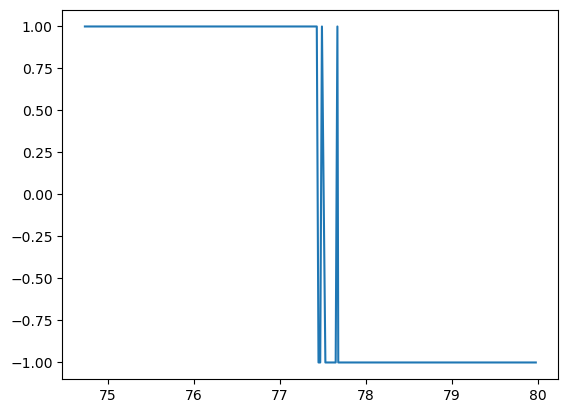

In [23]:
M = get_magnetisation(depth,params)
#M = get_magnetisation(depth,8.9,1.8,5.6,7.2)
plt.plot(depth,M)

In [24]:
initial_guess = np.array([2., 3., 7., 5.])

In [43]:
optimized_params = gradient_descent_with_momentum(fraction_data, depth, initial_guess, weight=0.5, momentum=0.9)

KeyboardInterrupt: 

In [40]:
optimized_params 

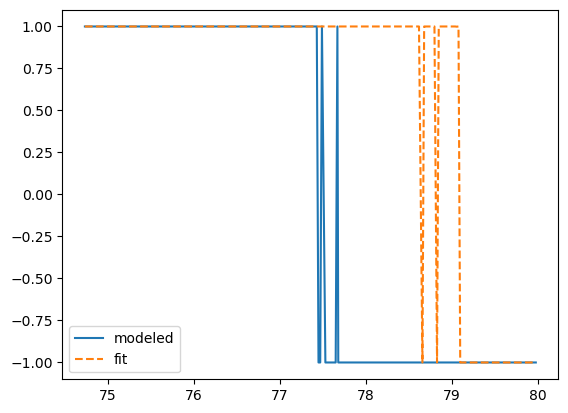

In [35]:
plt.plot(depth,M,label = 'modeled')
plt.plot(depth,get_magnetisation(depth,optimized_params),label = 'fit',linestyle = 'dashed')
plt.legend()
plt.savefig('test')
plt.show()

In [41]:
l_initial = l(4,depth,params[0],params[2],params[1],params[3])
l_fit = l(4,depth,optimized_params[0],optimized_params[2],optimized_params[1],optimized_params[3])

plt.plot(depth,l_initial,label = 'modeled')
plt.plot(depth,l_fit,label = 'fit',linestyle = 'dashed')
plt.legend()
plt.savefig('test_lock-in')
plt.show()

ValueError: operands could not be broadcast together with shapes (0,) (212,) 

[1.9, 3.1, 8.0, 5.0]